In [50]:
#README FIRST: Data Cleaning, Munging and EDA File for Project Three
import os
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_rows', 5) #Ensure this is here to avoid elongating the file
from nltk.corpus import stopwords # Import the stop word list
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/ben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading in All Data

In [3]:
# Directory path
directory_path = '../data'

# Create an empty list to store DataFrames
dfs_list = []

# Loop through list
for i in range(1, 53):
    # Construct the file path based on the pattern
    file_path = os.path.join(directory_path, f'df_d{i}.csv')
    
    # Check if the file exists before attempting to read it
    if os.path.exists(file_path):
        # Read CSV into DataFrame
        df = pd.read_csv(file_path)
        # Append DataFrame to the list
        dfs_list.append(df)

# Concatenate DataFrames in the list
df_dem = pd.concat(dfs_list).reset_index(drop=True)

# Create an empty list to store DataFrames
dfs_list_rep = []

# Loop through list
for i in range(1, 53):
    # Construct the file path based on the pattern
    file_path_r = os.path.join(directory_path, f'df_r{i}.csv')
    
    # Check if the file exists before attempting to read it
    if os.path.exists(file_path_r):
        # Read CSV into DataFrame
        df_rep = pd.read_csv(file_path_r)
        # Append DataFrame to the list
        dfs_list_rep.append(df_rep)

# Concatenate DataFrames in the list
df_rep = pd.concat(dfs_list_rep).reset_index(drop=True)

#### NOTE:  The drop_duplicates() method removes duplicate rows. Use the subset parameter if only some specified columns should be considered when looking for duplicates.


### Drop duplicates

In [4]:
df_dem = df_dem.drop_duplicates(inplace=False, ignore_index=True)

In [5]:
df_rep = df_rep.drop_duplicates(inplace=False, ignore_index=True)

### Drop Superfluous Columns

In [6]:
columns_to_drop = ['selftext', 'created_utc','name','0']

# for df_dem
df_dem = df_dem.drop(columns=columns_to_drop)

# for df_rep
df_rep = df_rep.drop(columns=columns_to_drop)

### Visual inspection

In [7]:
df_dem

,title,subreddit,comments
0,Georgia Prosecutors Had Tense Exchange on Raci...,democrats,NaN
1,Biden's campaign pushes abortion rights in bat...,democrats,NaN
...,...,...,...
2783,WHAT JOE BIDEN HAS DONE,democrats,NaN
2784,Calls for southern states to mobilize troops t...,democrats,NaN


In [8]:
df_rep

,title,subreddit
0,Texas Refuses To Comply With Federal Governmen...,Republican
1,"Florida Bans State, Federal Funding For DEI At...",Republican
...,...,...
2635,Pro Palestinian radical caught mid tirade verb...,Republican
2636,Texas AG is “saying the Department of Homeland...,Republican


#### Prior to combining these dataframes, we look at the most common words in each of these dataframes in order to gain a better understanding regarding the type of language our model will focus upon in order to characterize texts as belonging to each one. 

In [54]:
# Get English stopwords
stop_words = set(stopwords.words('english'))

# Function to tokenize, remove stopwords, remove punctuation, and count words
def tokenize_and_count(df):
    all_words = []
    for post in df['title']:
        if isinstance(post, str):
            # Remove punctuation using regex
            post = re.sub(r'[^\w\s]', '', post)
            words = word_tokenize(post)
            # Remove stopwords
            words = [word.lower() for word in words if word.lower() not in stop_words]
            all_words.extend(words)
    word_counts = Counter(all_words)
    return word_counts
    
# Tokenize and count words for both dataframes
dem_word_counts = tokenize_and_count(df_dem)
rep_word_counts = tokenize_and_count(df_rep)

In [55]:
# Get top 20 words for each dataframe
top_dem_words = dem_word_counts.most_common(20)
top_rep_words = rep_word_counts.most_common(20)

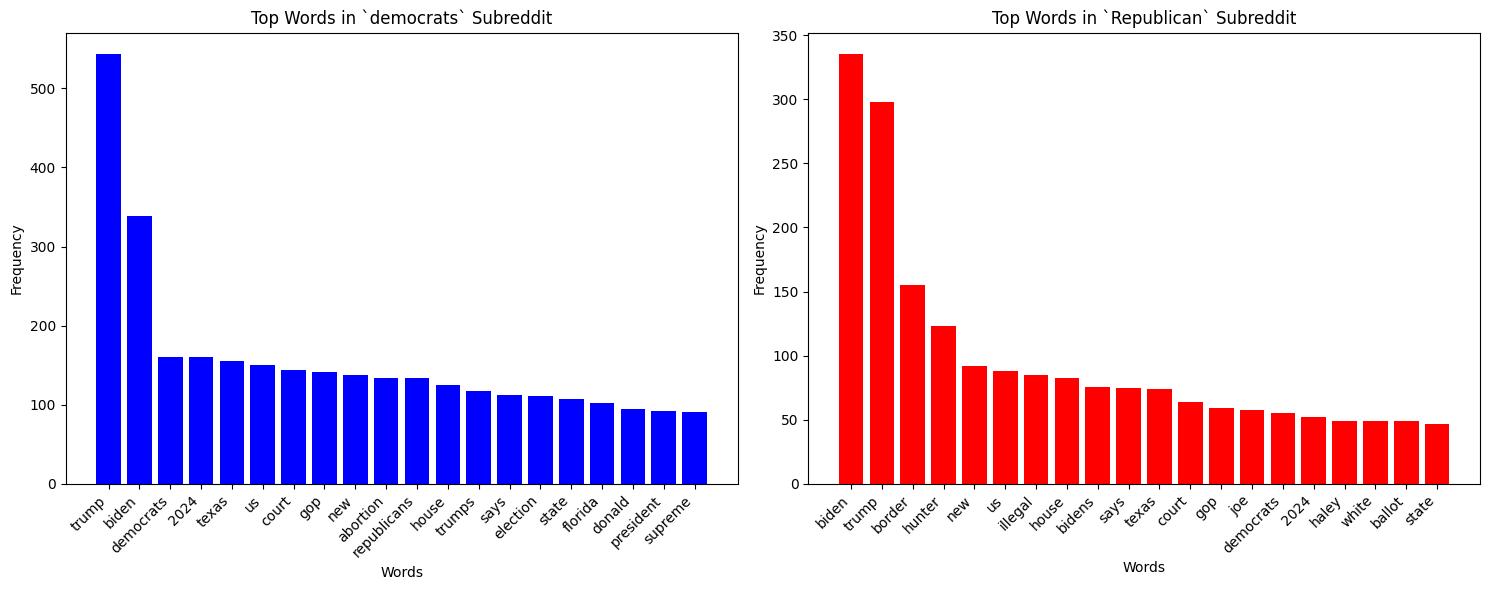

In [57]:
# Plot histograms
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(range(len(top_dem_words)), [count for word, count in top_dem_words], align='center', color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Words in `democrats` Subreddit')
plt.xticks(range(len(top_dem_words)), [word for word, count in top_dem_words], rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(range(len(top_rep_words)), [count for word, count in top_rep_words], align='center', color='red')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Words in `Republican` Subreddit')
plt.xticks(range(len(top_rep_words)), [word for word, count in top_rep_words], rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### From a domain-knowledge standpoint, this makes a lot of sense! We will not pursue a custom stopwords list as these words diverge in similarity past the two presidential candidate names.

### Combining Dataframes 

In [9]:
df_both = pd.concat([df_dem, df_rep]).reset_index(drop=True)
df_both

,title,subreddit,comments
0,Georgia Prosecutors Had Tense Exchange on Raci...,democrats,NaN
1,Biden's campaign pushes abortion rights in bat...,democrats,NaN
...,...,...,...
5420,Pro Palestinian radical caught mid tirade verb...,Republican,NaN
5421,Texas AG is “saying the Department of Homeland...,Republican,NaN


### Dummifying the `subreddit` Column

In [10]:
# Democrats, denoted 1, are taken to be the positive class 

df_both['subreddit'] = np.where(df_both['subreddit'] == 'democrats', 1, 0)

In [11]:
# pd.set_option('display.max_rows', None)
df_both

,title,subreddit,comments
0,Georgia Prosecutors Had Tense Exchange on Raci...,1,NaN
1,Biden's campaign pushes abortion rights in bat...,1,NaN
...,...,...,...
5420,Pro Palestinian radical caught mid tirade verb...,0,NaN
5421,Texas AG is “saying the Department of Homeland...,0,NaN


#### The following steps are to remove comments from these dataframes after a few previous attempts at including them within the data gathering process. The reason comments ended up being excluded was that the `Republican` subreddit was heavily moderated and thus too many comments were redacted from the record, causing a class imbalance between `democrats` and `Republican` subreddits. Furthermore, the `democrats` subreddit was sparsely moderated, and infighting in the comments skewed statistical analysis. These were two issues with including comments at the time of this project (February 2024) and they may have been resolved since the conclusion of this study. Thus, comments will be removed in the following few cells of this notebook from previously obtained and concatenated dataframes. 

In [13]:
# Step 1: Create a mask for rows where both 'title' and 'comments' are occupied
mask = (pd.notna(df_both['title'])) & (pd.notna(df_both['comments']))

# Step 2: Replace 'title' with 'comments' for the selected rows
df_both.loc[mask, 'title'] = df_both.loc[mask, 'comments']

# Step 3: Optional - Empty the 'comments' column
df_both['comments'] = ''

# Display the DataFrame
df_both

,title,subreddit,comments
0,Georgia Prosecutors Had Tense Exchange on Raci...,1,
1,Biden's campaign pushes abortion rights in bat...,1,
...,...,...,...
5420,Pro Palestinian radical caught mid tirade verb...,0,
5421,Texas AG is “saying the Department of Homeland...,0,


#### Must drop the moderator autogenerated rows. We use the most common identifying phrase in the strings to remove these comments.  

In [14]:
# Create a mask to identify rows with the moderator text blanking the comment
mask = df_both['title'].str.contains("This is a place for Republicans to discuss issues with other Republicans.")

# Replace NaN values in the mask with False
mask = mask.fillna(False)

# Use the boolean mask to select rows that meet the condition
df_filtered = df_both[~mask]

# Drop rows with NaN values in the 'title' column
df_filtered.dropna(subset=['title'], inplace=True)

# Reset index if needed
df_filtered.reset_index(drop=True, inplace=True)

In [15]:
# Display the resulting DataFrame
df_filtered

,title,subreddit,comments
0,Georgia Prosecutors Had Tense Exchange on Raci...,1,
1,Biden's campaign pushes abortion rights in bat...,1,
...,...,...,...
4227,Pro Palestinian radical caught mid tirade verb...,0,
4228,Texas AG is “saying the Department of Homeland...,0,


#### Finally, remove comments from the `democrats` subreddit. 

In [16]:
# Remove the comments from `democrats` subreddit
mask = df_filtered['title'].str.contains("{'body':")

# Invert the mask to select rows without the specified tag
df_filtered = df_filtered[~mask]

In [17]:
df_filtered.shape

(3478, 3)

In [18]:
df_filtered

,title,subreddit,comments
0,Georgia Prosecutors Had Tense Exchange on Raci...,1,
1,Biden's campaign pushes abortion rights in bat...,1,
...,...,...,...
4227,Pro Palestinian radical caught mid tirade verb...,0,
4228,Texas AG is “saying the Department of Homeland...,0,


### Export and save newly formatted Dataframe as `.csv` file

### As before in the previous file, change tag to reflect the scrapes being loaded 

In [40]:
df_filtered.to_csv('../data/final_df_to53.csv', index=False) # includes 1-52

# Preprocessing Section ( Regular Expressions ) 

In [39]:
df = pd.read_csv('../data/final_df_to48.csv')

In [21]:
df.shape

(3397, 3)

In [23]:
# Number of Democrat Posts
len(df[df['subreddit'] == 1])

1797

In [24]:
# Number of Republican Posts
len(df[df['subreddit'] == 0])

1600

#### The disparity between party post totals is minimal, proceed to cleaning section. 

# Preliminary Cleaning Section

### Purpose of this section:
1. Instantiate the `train-test-test` split
1. Clean the data using regular expressions and a custom censoring function
1. Create stopwords that will be used in the modeling section

In [29]:
"""
Create train_test_split.
90 train size
Generate confusion matrices for these models after fitting and scoring. 
"""
X_train, X_test, y_train, y_test = train_test_split(df['title'],
                                                    df['subreddit'],
                                                    train_size = 0.90,
                                                    random_state = 42)

In [30]:
def posts_to_words(train_data):
    """
    Function to convert a raw post to a string of words
    The input is a single string (a raw subreddit title), and 
    the output is a single string (a preprocessed subreddit post)
    """
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", train_data)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

total_posts = df.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the clean reviews.
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing the training set subreddit posts...")

j = 0
for train_posts in X_train:
    # Convert review to words, then append to clean_train_reviews.
    clean_train_posts.append(posts_to_words(train_posts))
    
    # If the index is divisible by 1000, print a message
    if (j + 1) % 500 == 0:
        print(f'Post {j + 1} of {total_posts}.')
    
    j += 1

# Do the same for testing set.

print("Cleaning and parsing the testing set subreddit posts...")


There are 3397 posts.
Cleaning and parsing the training set subreddit posts...
Post 500 of 3397.
Post 1000 of 3397.
Post 1500 of 3397.
Post 2000 of 3397.
Post 2500 of 3397.
Post 3000 of 3397.
Cleaning and parsing the testing set subreddit posts...


In [31]:
# Censor function with regular expressions to eliminate variations of foul language
def censor(text, banned):
    for word in banned:
        text = re.sub(rf'\b{re.escape(word)}(?:\w*)\b', '*' * len(word), text, flags=re.IGNORECASE)
    return text
# Sample output
print(censor('Chick-chick-Chicken sandwich, I love a good chicken sandwich; vanilla ice cream dessert.', ['chick', 'cream']))

*****-*****-***** sandwich, I love a good ***** sandwich; vanilla ice ***** dessert.


#### `censor` function performs adequately and is utilized in the following block of code.

In [32]:

for test_posts in X_test:
    # Convert review to words, then append to clean_train_reviews.
    clean_test_posts.append(posts_to_words(test_posts))
    
    # If the index is divisible by 1000, print a message
    if (j + 1) % 1000 == 0:
        print(f'Post {j + 1} of {total_posts}.')
        
    j += 1

clean_train_posts

np.mean(len(clean_train_posts))

# Applying censor function to each element in clean_train_posts
censored_posts_train = [censor(post, ['shit', 'fuck']) if post else '' for post in clean_train_posts]
"""
Please forgive the authors foul language! 

Print the censored posts - commented out to reduce notebook length
for censored_post in censored_posts_train:
     print(censored_post)

# Applying censor function to each element in clean_train_posts
"""
censored_posts_test = [censor(post, ['shit', 'fuck']) if post else '' for post in clean_test_posts]

""" 
Print the censored posts - Commented out to reduce notebook length
 for censored_post in censored_posts_test:
     print(censored_post)
"""

#### Note: Emojis are being turned into blank character (''); when `censor` function is applied these lines are completely wiped out. The loss is minimal and its effect negligible in total performance, as will be seen in the following sections. 

In [33]:
censored_posts_train

['nato official warns west ready anything',
 'trump coup part maga gop enablers apparently plotting crown trump king',
 'migrants waiting shelter beds using nyc park bathroom',
 'democrats plan spend millions weaken republican supermajorities',
 'marc elias moderate republicans either proud maga scared maga',
 'election analysis teen pregnancy texas edition',
 'jihadist worst nightmare jews armed ready',
 'enough said',
 'biden urged federal officials examine marijuana classification october federal scientists recommend easing restrictions ganja',
 'claudine gay harvard',
 'retirement without net plight america aging farmworkers',
 'rudy giuliani files chapter bankruptcy new york defamation case',
 'exclusive gop drafting bills remove biden ballots ga az pa',
 'wild video captures nyc driver getting car shove anti israel protesters disrupting traffic idiots',
 'bc white student gpa sat rejected cornell university race viral video claims',
 'scott perry texts shown line courts',
 'wait 

In [38]:
type(censored_posts_test)

list

In [37]:
type(y_train)

pandas.core.series.Series

In [36]:
y_test

291     1
2736    0
       ..
263     1
817     1
Name: subreddit, Length: 340, dtype: int64

#### Save these objects for loading in the `ProjectModeling_v2.ipynb` file

In [41]:
# Convert lists to DataFrame
censored_train_df = pd.DataFrame({'posts': censored_posts_train})
censored_test_df = pd.DataFrame({'posts': censored_posts_test})

# Convert Series to DataFrame
y_train_df = pd.DataFrame({'label': y_train})
y_test_df = pd.DataFrame({'label': y_test})

# Save DataFrames to CSV files
censored_train_df.to_csv('../data/censored_train.csv', index=False)
censored_test_df.to_csv('../data/censored_test.csv', index=False)
y_train_df.to_csv('../data/y_train.csv', index=False)
y_test_df.to_csv('../data/y_test.csv', index=False)

#### A couple notes that we share prior to transitioning to the modeling notebook. 

#### Note we have limited our text strings to alphabetical characters only. This is due to the fact that these are text comments and images are not able to be embedded within the titles. 

#### For the following section we are putting a particular emphasis on sensitivity. In other words, the goal is the achieve a result that yields a high probability of correctly predicting an "actual" positive example. The reason why we want this to be the case is that have chosen the `democrats` subreddit to be our positive class, and potentially misclassifying a `Republican` post as `democrats` and having that mixup exposed to our stakeholders would irritate them to no end! We need to make sure our predictions are locked in and differentiate effectively between the two subreddits! Thus, sensitivity has been prioritized. 